In [1]:
import numpy as np
import pandas as pd
from eda.desc_stats import show_desc
from eda.bin_iv_woe import cont_feature_bin,disc_feature_bin,woe_transform
from eda.data_preprocess import capping
import gc
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

样本准本

In [52]:
base_data = pd.read_csv('./data/input/wpqx_dq_variables.csv')
print(base_data.shape)
del base_data['Unnamed: 0']
cols = [i.split('.')[1] for i in base_data.columns]
base_data.columns = cols

base_data['create_date'] = base_data['create_date'].apply(lambda x:x[:7])

# label标签：due_fpd15,def_fpd15; due_mob2,def_mob2_30; due_mob3,def_mob3_30; due_mob6,def_mob6_30; 
def build_label(row):
    if row[1]==1:
        return 1
    elif row[1]==0 and row[0]==1:
        return 0
    else: 
        return 
# base_data['target'] = base_data[['due_mob2','def_mob2_30']].apply(build_label,axis=1)
base_data['target'] = base_data[['due_fpd15','def_fpd15']].apply(build_label,axis=1)
base_data = base_data[base_data['target'].notnull()].reset_index(drop=True)

feats = base_data.columns[24:-1].to_list()
jg_feats = pd.Series(feats)[pd.Series(map(lambda x:x[:2], feats))=='jg'].to_list()
bj_feats = pd.Series(feats)[pd.Series(map(lambda x:x[:2], feats))=='bj'].to_list()
br_feats = pd.Series(feats)[pd.Series(map(lambda x:x[:2], feats))=='br'].to_list()

cols = br_feats+['target']
base_data = base_data[cols]
base_data.shape

(185350, 2133)


(23954, 426)

In [2]:
base_data = pd.read_pickle('./data/input/base_data.pkl')
print(base_data.shape)
base_data.head()

(29188, 1441)


,id,ACAJ_ZCVA_BFVA_N2,ACAJ_ZCVC_BFVA_N2,ACAJ_ZCVC_BFVG_N2,ACAN_ZBVA_XAVA_BBVD_N1,ACAN_ZBVA_XAVB_BBVD_N8,ACAN_ZBVA_XAVF_BBVF_N6,ACAN_ZBVA_XAVR_BBVF_N9,ACAN_ZBVA_XAVU_BBVD_N3,ACAN_ZBVA_XAVU_BBVF_N2,...,REPAY_SGBH_YMD,REPAY_SGBI_YMD,REPAY_SGBL_YMC,REPAY_SGBL_YMD,REPAY_SGBM_MD,REPAY_SGBQ_MD,REPAY_SGBS_MD,REPAY_TEAB_MB,REPAY_TEAF_MB,target
1,2020091307524712366123,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
5,2020091309254489366392,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
6,2020091309255938267573,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,0,0,0.0
7,2020091309260832567276,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
8,2020091309262965666320,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


第一步 描述性统计和数据预处理

1. 数据取值。有效值、无效值(空值标识、默认值标识)
2. 不考虑id的情况下，对数据进行去重，即只看特征和标签的重复情况。

In [3]:
THE_EMPTY_FLAG = [np.nan, 'null', 'NULL', -999, '-999', 9999, -9998]
TO_EMPTY_STATUS = np.nan
base_data.replace(THE_EMPTY_FLAG, TO_EMPTY_STATUS, inplace=True) # preprocess1: 缺失值标识

del base_data['id']

row_desc = show_desc(base_data, detail=True)
# row_desc.to_excel('./data/output/wpqx_br_fests_desc_stats.xlsx')

原始数据集： (29188, 1440)
重复行数： 5
去重后数据集： (29183, 1440)
包含空值的字段个数： 88
数据类型分布： {dtype('O'): 2, dtype('float64'): 370, dtype('int64'): 1068}


In [4]:
base_data = base_data.drop_duplicates().reset_index(drop=True) # preprocess2: 特征+标签去重，不包括ID。
print(base_data.shape)

total_feats = base_data.columns.to_list()
total_feats.remove('target')

# del base_data['br_applyloanstr_createdate_onlycache']  # choose 2 删除日期字段
# total_feats.remove('br_applyloanstr_createdate_onlycache')

# base_data[total_feats] = base_data[total_feats].apply(capping) # preprocess2: 异常值处理

(29183, 1440)


In [9]:
import joblib
from model.metrics import acc_pre_recal_f1,pr_cover,roc_ks_cover
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import KFold
import os

from utils.func import setRandomSeed
setRandomSeed(2022)

In [11]:
class feature_select(object):
    """
    特征选择:缺失值与最大单一值占比,相关系数,IV,PSI,VIF,bad_rate单调性,逐步回归,模型系数符号与显著性.
    前序步骤:数据预处理
    """
    def __init__(self,df,feats,target,random=3017):
        self.df = df
        self.feats = feats
        self.target = target
        self.random = random
        
        self.df.reset_index(drop=True, inplace=True)
        self.train_idx,self.test_idx = train_test_split(self.df.index, test_size=0.3, random_state=self.random)
        
    def bins_and_iv(self, cont_bin='cut', dist_bin='cut'):
        """训练集上，各分箱上的描述统计"""
        # 单个分箱上的样本数不低于5%；单个分箱上的正负样本数不为0；
        # woe值应该按照分箱顺序单调；缺失值单独为一箱；
        self.bin_iv_woe_df = pd.DataFrame()
        for feat in self.feats:
            if self.df.loc[self.train_idx, feat].dtype.kind in 'ifc':
                woe_df = cont_feature_bin(self.df.loc[self.train_idx, [feat, self.target]], bin_type=cont_bin, bins=10)
            else:
                woe_df = disc_feature_bin(self.df.loc[self.train_idx, [feat, self.target]], bin_type=dist_bin, bins=10)
            woe_df = woe_df.reset_index().rename(columns={woe_df.index.name:'bin'})
            woe_df['feature'] = feat
            # cols = ['feature','bin', 'total', 'bad', 'bad_rate', 'lift', 'woe', 'iv']
            cols = ['feature','bin', 'bin_low', 'bin_up', 'total', 'bad', 'good', 'bad_rate', 'cum_total', 'cum_bad', 'lift', 'bad%', 'good%', 'woe', 'iv']
            self.bin_iv_woe_df = pd.concat([self.bin_iv_woe_df,woe_df[cols]],axis=0)

    def _filter_by_desc(self, missing=0.8, freq=0.9):
        """总体数据上选择"""
        row_desc = show_desc(self.df[self.feats], summary=False, detail=True)
        filter_feats = row_desc[(row_desc['null%']<missing)&(row_desc['freq%']<freq)].index.to_list()
        drop_feats = [feat for feat in self.feats if feat not in filter_feats]
        
        self.feats = filter_feats
        # if len(drop_feats)>0:
        #     self.df.drop(drop_feats,axis=1,inplace=True)
        print("选择缺失值占比小于{0}且最大单一值占比小于{1}的特征：{2}个。剔除变量{3}个。".format(missing, freq, len(self.feats), len(drop_feats)))

    def _filter_by_bins_iv(self, iv_filter=0.02):
        """"训练集上,iv筛选"""
        features_iv = self.bin_iv_woe_df[['feature', 'iv']].groupby('feature').agg('sum').squeeze() # IV求和
        filter_feats = features_iv>=iv_filter
        filter_feats = features_iv[filter_feats].index.values
        drop_feats = [feat for feat in self.feats if feat not in filter_feats]
        
        self.features_iv = features_iv[filter_feats]
        self.feats = self.features_iv.index.values
        print("选择分箱后IV大于等于{0}的特征：{1}个。剔除变量{2}个。".format(iv_filter, len(self.feats), len(drop_feats)))


    def _filter_by_corr(self, corr_filter=0.8):
        """训练集上,相关性筛选,提出相关性较高的变量中,iv较低的"""
        corr = self.df.loc[self.train_idx, self.feats].corr() # 皮尔逊相关系数
        features = corr.columns
        feature_num = corr.shape[0]
        feat_mask = np.full((feature_num,), True, dtype=bool)  # 保留变量

        for i in range(feature_num):
            if not feat_mask[i]: # 如果第i个feature已经被剔除，则继续看其他feature
                continue
            for j in range(i+1, feature_num):
                if feat_mask[j] and np.abs(corr.iloc[i,j]) > corr_filter:
                    if self.features_iv[features[i]]>=self.features_iv[features[j]]:
                        feat_mask[j] = False
                        continue
                    else:
                        feat_mask[i] = False
                        break
                else:
                    continue
        self.feats = features[feat_mask].values
        drop_feats = features[~feat_mask].values
        print("选择相关系数小于等于{0}的特征：{1}个。剔除变量{2}个。".format(corr_filter, len(self.feats), len(drop_feats)))


    def _filter_by_psi(self, psi_filter=0.1):
        """
        训练集、测试集进行woe转换后,psi筛选
        """
        self.train = woe_transform(self.df.loc[self.train_idx, self.feats], self.bin_iv_woe_df)
        self.test = woe_transform(self.df.loc[self.test_idx, self.feats], self.bin_iv_woe_df)

        total_psi_df = pd.DataFrame()
        for feat in self.feats:
            train_psi_df = self.train.groupby(feat, as_index=True)
            train_psi_df = train_psi_df.size().to_frame('train_cnt')
            train_sum = train_psi_df['train_cnt'].sum()
            train_psi_df['train_cnt'] = train_psi_df['train_cnt']/train_sum

            test_psi_df = self.test.groupby(feat, as_index=True)
            test_psi_df = test_psi_df.size().to_frame('test_cnt')
            test_sum = test_psi_df['test_cnt'].sum()
            test_psi_df['test_cnt'] = test_psi_df['test_cnt']/test_sum

            # psi_df = pd.concat([train_psi_df,test_psi_df], axis=1, join='left')
            psi_df = train_psi_df.merge(test_psi_df, how='left', left_index=True, right_index=True)
            psi_df.index.name='value'
            psi_df.reset_index(inplace=True)
            psi_df['feature'] = feat
            psi_df['psi'] = (psi_df['train_cnt']-psi_df['test_cnt'])*np.log(psi_df['train_cnt']/psi_df['test_cnt'])
            total_psi_df = pd.concat([total_psi_df, psi_df],axis=0)
        # return total_psi_df[['feature', 'value', 'train_cnt', 'test_cnt', 'psi']]
        self.features_psi = total_psi_df[['feature','psi']].groupby('feature').agg('sum').squeeze()
        filter_feats = self.features_psi[self.features_psi<=psi_filter].index.values
        drop_feats = self.features_psi[self.features_psi>psi_filter].index.values
        self.feats = filter_feats
        print("选择PSI小于等于{0}的特征：{1}个。剔除变量{2}个。".format(psi_filter, len(filter_feats), len(drop_feats)))


    def _filter_by_vif(self, vif_filter=10):
        """训练集上,vif筛选"""
        assert len(self.feats)==self.train.shape[1],"woe转换后的特征数应该与最终筛选的特征数一致!"
        vif = [variance_inflation_factor(self.train, i) for i in range(len(self.feats))]
        self.vif = pd.Series(vif, index=self.feats)
        filter_feats = self.vif[self.vif<=vif_filter].index.values
        drop_feats = self.vif[self.vif>vif_filter].index.values
        self.feats = filter_feats
        print("选择VIF小于等于{0}的特征：{1}个。剔除变量{2}个。".format(vif_filter, len(filter_feats), len(drop_feats)))

In [22]:
feat_selector = feature_select(base_data, total_feats, 'target', 2022)
feat_selector._filter_by_desc()
feat_selector.bins_and_iv(cont_bin='tree', dist_bin='value')
feat_selector._filter_by_bins_iv()
feat_selector._filter_by_corr()
feat_selector._filter_by_psi()
feat_selector._filter_by_vif()

选择缺失值占比小于0.8且最大单一值占比小于0.9的特征：365个。剔除变量1074个。
选择分箱后IV大于等于0.02的特征：127个。剔除变量238个。
选择相关系数小于等于0.8的特征：110个。剔除变量17个。
选择PSI小于等于0.1的特征：110个。剔除变量0个。
选择VIF小于等于10的特征：104个。剔除变量6个。


In [23]:
base_data['target'].value_counts()/base_data['target'].value_counts().sum()

0.0    0.882294
1.0    0.117706
Name: target, dtype: float64

建模

输出模型效果和模型文件

In [54]:
class AutoModelSearch(object):
    def __init__(self, feats, target, train, test):
        """
        在入模特征上进行建模、基于模型的特征筛选、评分卡构造、模型文档输出;
        前序步骤:特征预处理和特征筛选;
        """
        self.feats = feats
        self.target = target
        self.train,self.test = train,test

    def _search_lr_model(self,model):
        super_param = {
            'penalty':['l1','l2'],
            'C': [0.01, 0.1, 0.2, 0.5, 1],
            'class_weight': [{1: 1, 0: 1}, {1: 2, 0: 1}, {1: 3, 0: 1}, 'balanced'],
            }
        lr_search = GridSearchCV(
            estimator=model(random_state=2022, fit_intercept=True, solver='saga'),
            param_grid=super_param, cv=5, scoring='f1', n_jobs=-1, verbose=0)
        
        lr_search.fit(self.train[self.feats], self.train[self.target])
        print('逻辑模型最优得分 {0},\n最优参数{1}'.format(lr_search.best_score_,lr_search.best_params_))
        lr_model = model(C=lr_search.best_params_['C'], penalty=lr_search.best_params_['penalty'], solver='saga',
                                class_weight=lr_search.best_params_['class_weight'])
        lr_model.fit(self.train[self.feats], self.train[self.target])
        return lr_model

    def _search_dt_model(self,model):
        super_param = {
            'max_depth': np.arange(2,5,1),
            # 'class_weight': [{1: 1, 0: 1}, {1: 2, 0: 1}, {1: 3, 0: 1}],
            'class_weight': ['balanced'],
            'min_samples_leaf': [0.05],
            }
        tree_search = GridSearchCV(
            estimator=model(),
            param_grid=super_param, cv=5, scoring='f1', n_jobs=-1, verbose=0)
        tree_search.fit(self.train[self.feats], self.train[self.target])
        print('决策树模型最优得分 {0},\n最优参数{1}'.format(tree_search.best_score_,tree_search.best_params_))
        tree_model = model(max_depth = tree_search.best_params_['max_depth'],
            class_weight=tree_search.best_params_['class_weight'])
        tree_model.fit(self.train[self.feats], self.train[self.target])
        return tree_model

    def _learning_rate_010_decay_power_0995(current_iter):
        base_learning_rate = 0.1
        lr = base_learning_rate  * np.power(.995, current_iter)
        return lr if lr > 1e-3 else 1e-3
    
    def _search_lgbm_model(self):
        set_params = {
            'n_estimators': 200,
            'early_stopping_round': 50,
            'random_state': 2021,
            'n_jobs': 2,
            'class_weight': 'balanced'
        }
        search_params = {
            'max_depth': sp_randint(8, 32),                     # [2, 63]
            'num_leaves': sp_randint(32, 128),                  # [7, 4095]
            'bagging_fraction': sp_uniform(loc=0.4, scale=0.6), # als subsample、bagging。随机选择数据样本的比率，取值介于0-1之间的实数，默认为1。可以加速训练过程并降低过拟合。
            'feature_fraction': sp_uniform(loc=0.4, scale=0.6), # als colsample_bytree。用于在每棵树随机选择部分的特征集合，取值介于0-1之间的实数，默认为1。可以加速训练过程并降低过拟合。
            # 'feature_fraction_bynode': ,  # als colsample_bynode。用于每个树节点的特征选择，取值介于0-1之间，默认为1。
            # 'pos_bagging_fraction': ,  # 在bagging_fraction随机选择数据样本时，对正样本的选择比率为pos_samples * pos_bagging_fraction，取值介于0-1之间的实数，默认为1。需要和参数bagging_freq、neg_bagging_fraction同时使用。只能应用于二分类，可以抑制数据偏斜问题。别名包括：pos_sub_row、pos_subsample、pos_bagging。
            # 'neg_bagging_fraction': ,  # 类比于pos_bagging_fraction参数，作用于选择负样本neg_samples * neg_bagging_fraction个数，默认取值为1。当neg_bagging_fraction和pos_bagging_fraction都为1时，即为非平衡选择样本。如果指定平衡选择样本，那么bagging_fraction参数会被忽略。
            # 'bagging_freq': ,          # als subsample_freq。用于：指定的每K次迭代选择bagging_fraction样本，取值为整数K，默认为0。需要和参数bagging_fraction一起使用。
            'min_child_weight': sp_uniform(loc=0.01, scale=29), # [0.01, (sample size / 1000)] dataset-dependent and loss-dependent
            'min_child_samples': sp_randint(50, 200),
            'min_gain_to_split': sp_uniform(loc=0.2, scale=0.2), # als min_split_gain。最小分割收益，default is 0
            # 'lambda_l1': [1, 5, 10, 20, 50],   # als reg_alpha。 L1正则强度，默认为0
            # 'lambda_l2': [0, 1, 10],         # als reg_lambda。 L2正则强度，默认为0
            'lambda_l1': sp_randint(0, 50),   # als reg_alpha。 L1正则强度，默认为0
            'lambda_l2': sp_randint(0, 50),   # als reg_lambda。 L2正则强度，默认为0
        }
        clf = lgb.LGBMClassifier(**set_params)
        gs = RandomizedSearchCV(  #RandomizedSearchCV内部通过并行来提速。
                estimator=clf, 
                param_distributions=search_params,
                scoring='roc_auc',
                cv=5,
                verbose=1
                # refit=True,    # default True
                )
        gs.fit(self.train[self.feats], self.train[self.target], eval_set=(self.test[self.feats], self.test[self.target]))
        # print('Best score reached:', gs.best_score_)
        # print('Best params: ', gs.best_params_)
        best_params = gs.best_estimator_.get_params()
        clf = lgb.LGBMClassifier(**best_params)
        # clf.fit(self.train[self.feats], self.train[self.target], callbacks=[lgb.reset_parameter(learning_rate=_learning_rate_010_decay_power_0995)])
        return clf


    def model_search(self):
        """搜索ks、auc最高的模型"""
        cand_models = {
            'lr':LogisticRegression,
            'decision_tree':DecisionTreeClassifier,
            'lgbm':None
            }
        cand_models_metrics = {}
        # 所有的best_model均进行5折交叉看最后的预测值。
        for name,model in cand_models.items():
            if name=='lr':
                best_model = self._search_lr_model(model)
                print('{0} 模型最优指标：'.format(name))
                y_pred = best_model.predict(self.test[self.feats])
                y_pred_prob = best_model.predict_proba(self.test[self.feats])[:,1]
                y_true = self.test[self.target]
                acc,precision,recall,f1 = acc_pre_recal_f1(y_true, y_pred)
                auc, ks = roc_ks_cover(y_true, y_pred_prob)
                cand_models_metrics[best_model]= [auc, ks]

            elif name=='decision_tree':
                best_model = self._search_dt_model(model)
                print('{0} 模型最优指标：'.format(name))
                y_pred = best_model.predict(self.test[self.feats])
                y_pred_prob = best_model.predict_proba(self.test[self.feats])[:,1]
                y_true = self.test[self.target]
                acc,precision,recall,f1 = acc_pre_recal_f1(y_true, y_pred)
                auc, ks = roc_ks_cover(y_true, y_pred_prob)
                cand_models_metrics[best_model]= [auc, ks]

            elif name=='lgbm':
                best_model = self._search_lgbm_model()
                folds = KFold(n_splits=5, shuffle=True)
                nflod_train_preds = []
                nflod_valid_preds = np.zeros(self.train.shape[0])
                oof_preds = np.zeros(self.test.shape[0])
                # feature_importance_df = pd.DataFrame()
                for n_fold, (train_idx, valid_idx) in enumerate(folds.split(self.train)):
                    print(self.train.shape)
                    print(len(train_idx), len(valid_idx))
                    # best_model.fit(
                    #     self.train.loc[train_idx, self.feats], 
                    #     self.train.loc[train_idx, self.target],
                    #     eval_set=(self.train.loc[valid_idx, self.feats], self.train.loc[valid_idx, self.target]),
                    #     eval_metric='auc', verbose=False, early_stopping_rounds=200)
                    best_model.fit(
                        self.train.loc[train_idx, self.feats], 
                        self.train.loc[train_idx, self.target],
                        eval_set=(self.train.loc[valid_idx, self.feats], self.train.loc[valid_idx, self.target]),
                        eval_metric='auc', verbose=False)

                    train_pred = best_model.predict_proba(self.train.loc[train_idx, self.feats], 
                                                            num_iteration=best_model.best_iteration_)[:, 1]
                    nflod_valid_preds[valid_idx] = best_model.predict_proba(self.train.loc[valid_idx, self.feats], 
                                                                            num_iteration=best_model.best_iteration_)[:, 1]
                    oof_preds += best_model.predict_proba(self.test[self.feats],
                                                            num_iteration=best_model.best_iteration_)[:, 1]/folds.n_splits
                train_auc, train_ks = roc_ks_cover(self.train.loc[train_idx, self.target], train_pred)
                nflod_train_preds.append(train_auc)
                val_auc, val_ks = roc_ks_cover(self.train[self.target], nflod_valid_preds)
                test_auc, test_ks = roc_ks_cover(self.test[self.target], oof_preds)

                cand_models_metrics[best_model]= [test_auc, test_ks]
        
        # 按照KS取最高的一个模型
        cand_models_metrics = dict(sorted(cand_models_metrics.items(), key=lambda x:x[1][1], reverse=True))
        # print(cand_models_metrics)
        # return list(cand_models_metrics.keys())[0]
        self.best_model = list(cand_models_metrics.keys())[0]

In [55]:
# build input
cols = np.append(feat_selector.feats,feat_selector.target)
train,test = train_test_split(feat_selector.df[cols], test_size=0.3, random_state=2022)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train[feat_selector.feats] = woe_transform(train[feat_selector.feats], feat_selector.bin_iv_woe_df)
test[feat_selector.feats] = woe_transform(test[feat_selector.feats], feat_selector.bin_iv_woe_df)

逻辑模型最优得分 0.27871282666338837,
最优参数{'C': 0.2, 'class_weight': 'balanced', 'penalty': 'l2'}
lr 模型最优指标：
数据集上的混淆矩阵：
         预测结果为正例  预测结果为反例
真实样本为正例     4507     3180
真实样本为反例      451      617
----------------------------------------
模型预测的正确率: 0.5852655625356938
模型的精准率： 0.16249670792731102
模型的召回率： 0.5777153558052435
模型的f1值： 0.2536485097636177
roc取线: (auc值0.6154386461115099)


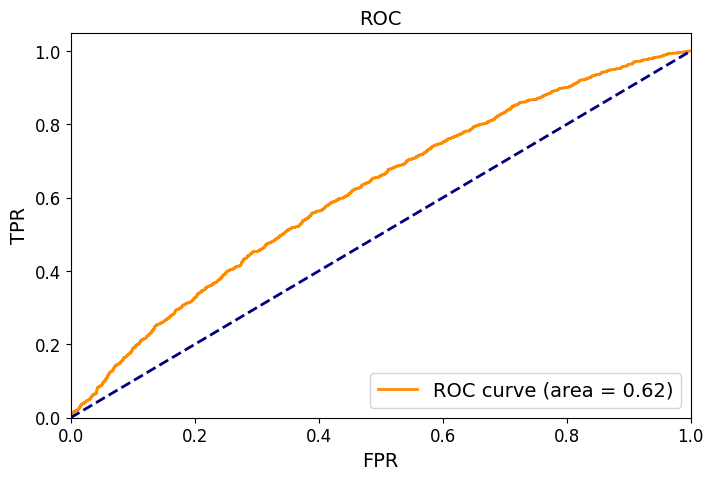

------------------------------------------------------------
ks曲线: (ks值0.16921413603101498)


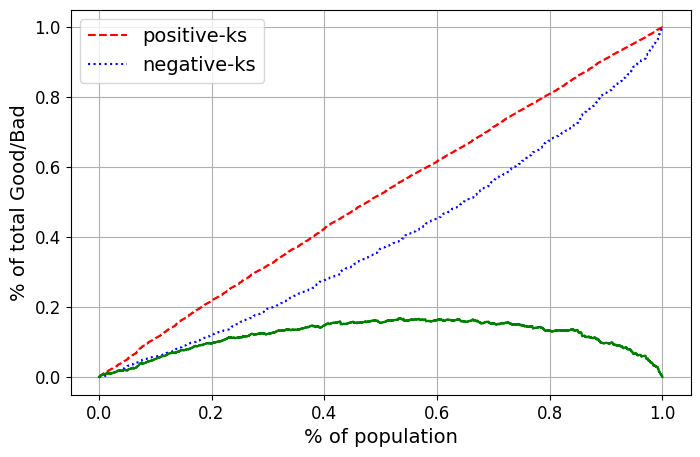

决策树模型最优得分 0.24055155843018947,
最优参数{'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 0.05}
decision_tree 模型最优指标：
数据集上的混淆矩阵：
         预测结果为正例  预测结果为反例
真实样本为正例     3958     3729
真实样本为反例      393      675
----------------------------------------
模型预测的正确率: 0.5291833238149629
模型的精准率： 0.15326975476839236
模型的召回率： 0.6320224719101124
模型的f1值： 0.24671052631578946
roc取线: (auc值0.5965058352810255)


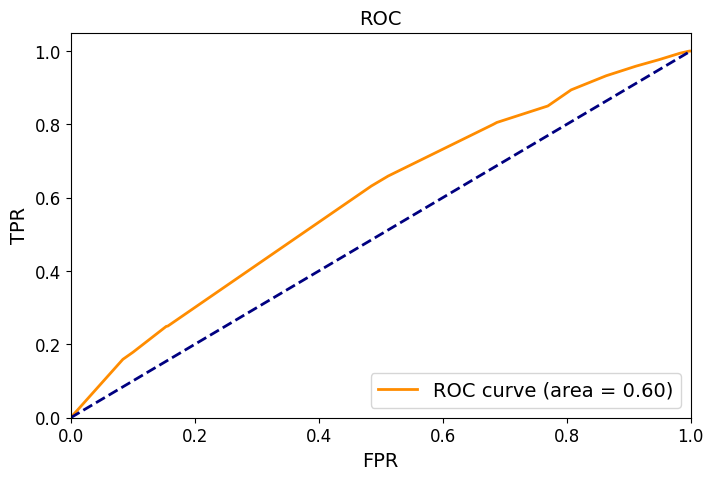

------------------------------------------------------------
ks曲线: (ks值0.14701263722155544)


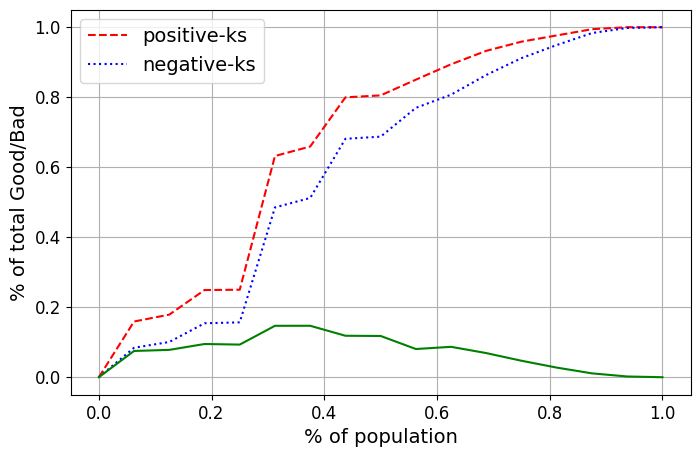

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] min_gain_to_split is set=0.33861411750218084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33861411750218084
[LightGBM] [Warning] feature_fraction is set=0.40169539329297893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40169539329297893
[LightGBM] [Warning] bagging_fraction is set=0.7156962838815775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156962838815775
[LightGBM] [Warning] lambda_l2 is set=39, reg_lambda=0.0 will be ignored. Current value: lambda_l2=39
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[1]	valid_0's binary_logloss: 0.688299
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.684813
[3]	valid_0's binary_logloss: 0.682309
[4]	valid_0's binary_logloss: 0.678668
[5]	valid_0's binary_logloss: 0.675867
[6]	valid_0's binary_

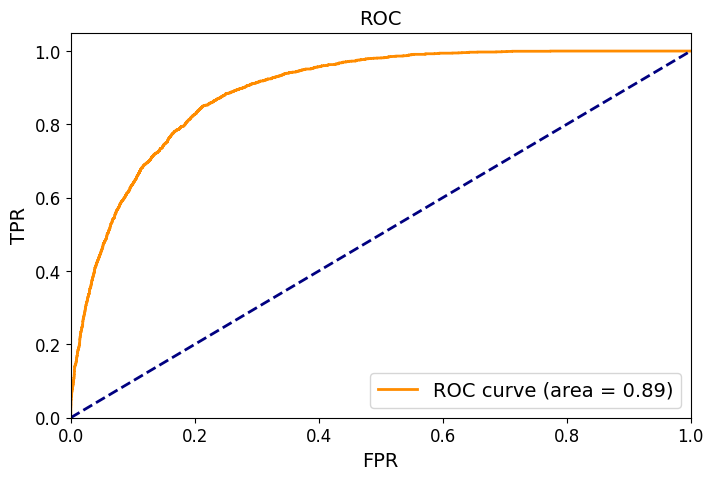

------------------------------------------------------------
ks曲线: (ks值0.6370718078237625)


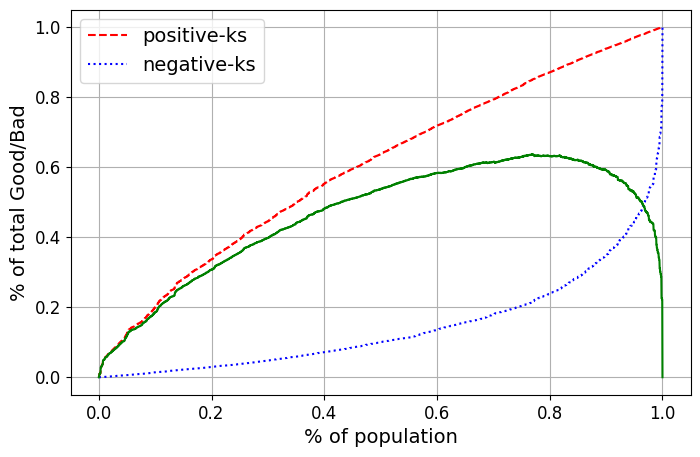

roc取线: (auc值0.6857794527099836)


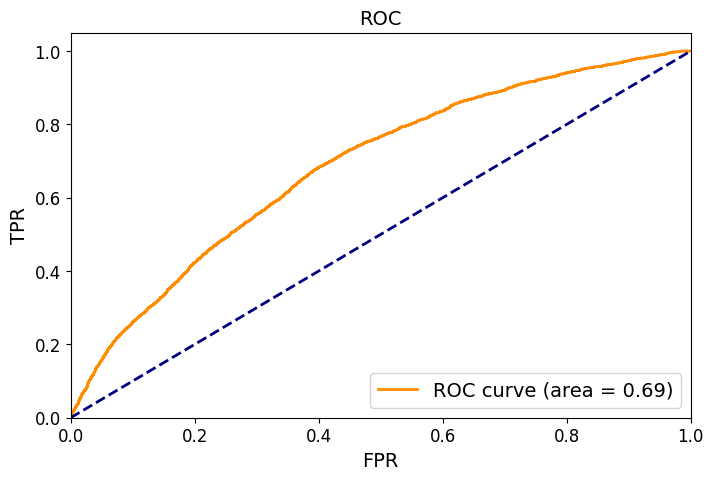

------------------------------------------------------------
ks曲线: (ks值0.28279353354157943)


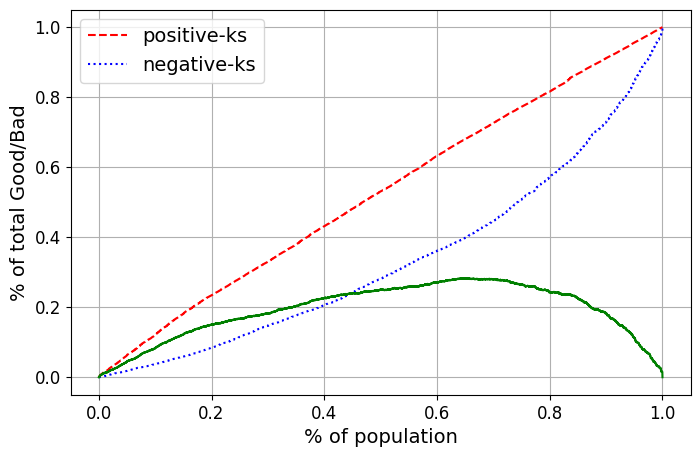

roc取线: (auc值0.6308165227640031)


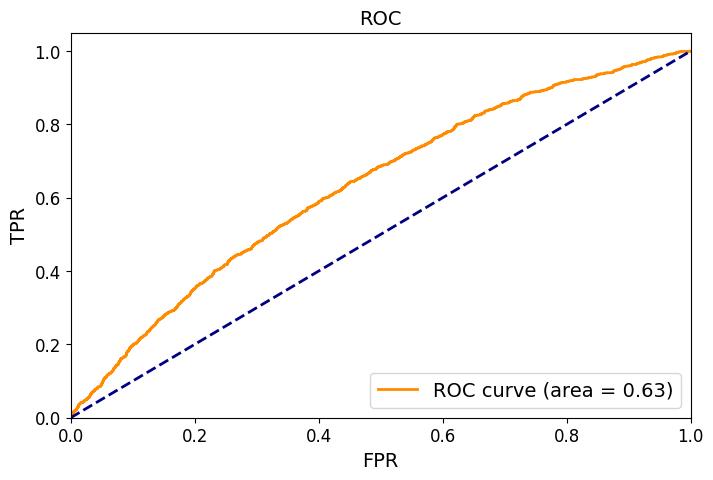

------------------------------------------------------------
ks曲线: (ks值0.19330364168504732)


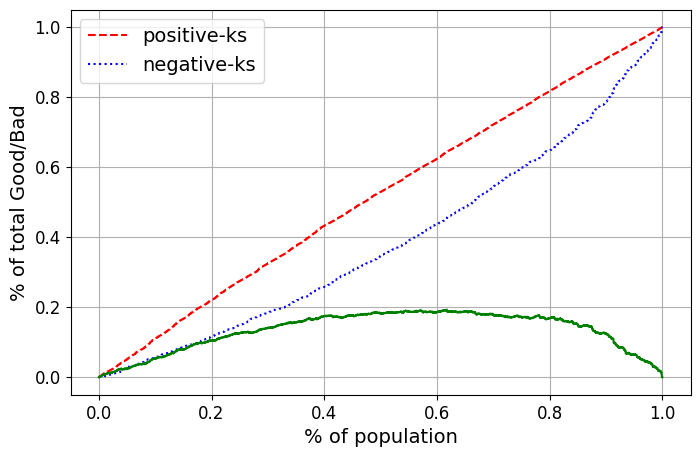

In [56]:
auto_ml = AutoModelSearch(feat_selector.feats, feat_selector.target, train, test)
auto_ml.model_search()

模型应用

生成评分卡、评分转换、风险等分表。

In [57]:
class BuildScoreCard(object):
    def __init__(self, model, feats, target, bin_woe_df):
        self.best_model=model
        self.feats = feats
        self.target = target
        self.bin_iv_woe_df = bin_woe_df

    def _score_params(self, base_point=600, odds=1/20, PDO=20):
        """
        给定基准分数、翻倍分数、PDO
        确定转换参数A、B
        """
        B = PDO/np.log(2)
        A = base_point + B*np.log(odds)
        print("(信用分)评分卡base_point:{0},odds:{1},PDO:{2}".format(base_point,odds,PDO))
        return A,B

    def build_score_card(self):
        """根据训练好的模型构造评分卡"""
        # 假设 Odds 在 1:60 时对应的参考分值为 600 分, 分值调整刻度 PDO 为 20, 则计算得到分值转化的参数 B = 28.85, A= 481.86。
        # score = A - B*log(p/(1-p))
        # 提取入模变量的权重
        model_params = list(self.feats)
        model_params.append('intercept')
        weight_value = list(self.best_model.coef_.flatten())  # 系数
        weight_value.extend(list(self.best_model.intercept_))  # 截距
        dict_params = dict(zip(model_params,weight_value))
        # 基准分
        params_A,params_B = self._score_params(base_point=600, odds=1/20, PDO=20)
        base_points = round(params_A - params_B * dict_params['intercept']) # 基准分，已包含截距
        print("基准分:{0}，已包含截距".format(base_points))
        # 样本得分转换
        x_features_bin_score = self.bin_iv_woe_df[self.bin_iv_woe_df['feature'].isin(self.feats)][['feature','bin','woe']]
        x_features_bin_score = pd.merge(
            x_features_bin_score
            ,pd.Series(dict_params,name='weight').to_frame()
            ,how='left',left_on='feature',right_index=True
            )
        x_features_bin_score['score'] = round(-params_B*x_features_bin_score['woe']*x_features_bin_score['weight'])
        base_score = {'feature':'base_points', 'bin':np.nan, 'woe':np.nan, 'weight':np.nan, 'score':base_points}
        x_features_bin_score = x_features_bin_score.append(base_score, ignore_index=True)
        
        self.score_card = x_features_bin_score
        self.base_score = base_points
        self.score_card_params_A,self.score_card_params_B = params_A,params_B

    def _sample_score(self, df):
        """
        对数据集进行打分，并验证分数的风险识别能力
        df已经过woe转换
        """
        # dataframe转换成字典，提高检索速度
        # dict_bin_score = dict(self.score_card.groupby('feature')[['woe','score']].apply(lambda x:dict(zip(x['woe'],x['score']))))
        for feat in self.feats:
            woe_score = self.score_card[self.score_card['feature']==feat][['woe', 'score']]
            transformed = np.zeros(len(df[feat]))
            for id,row in woe_score.iterrows():
                mask = (df[feat]==row['woe'])
                transformed[mask] = row['score']
            df.loc[:, feat] = transformed
        df['model_score'] = df[self.feats].sum(axis=1) + self.base_score
        return df
        
    def use_model_score(self, df):
        """信用分风险等分表"""
        score_df = self._sample_score(df)
        total_size = score_df[self.target].count()
        total_bad = score_df[self.target].sum()
        total_bad_rate = total_bad/total_size

        score_df['score_bin'] = pd.qcut(score_df['model_score'], q=20, duplicates='drop')
        cols = ['model_score','score_bin',self.target]
        bin_df = score_df[cols].groupby('score_bin')
        woe_df = pd.DataFrame(bin_df.size(), columns=['total'])
        woe_df['bad'] = bin_df[self.target].sum()
        woe_df['good'] = woe_df['total']-woe_df['bad']
        woe_df['bad_rate'] = woe_df['bad']/woe_df['total']
        woe_df['cum_total'] = woe_df['total'].cumsum()
        woe_df['cum_bad'] = woe_df['bad'].cumsum()
        woe_df['lift'] = woe_df['cum_bad']/woe_df['cum_total']/total_bad_rate
        
        return woe_df,score_df[['target','model_score','score_bin']]

In [58]:
score_card = BuildScoreCard(auto_ml.best_model, feat_selector.feats, feat_selector.target, feat_selector.bin_iv_woe_df)
score_card.build_score_card()
model_score_bin_df, scored_df = score_card.use_model_score(train.copy())
model_score_bin_df

AttributeError: 'LGBMClassifier' object has no attribute 'coef_'

In [59]:
scored_df.groupby('target').agg({'model_score':'mean'})

NameError: name 'scored_df' is not defined

In [9]:
# PROJECT_ROOT_DIR = "./data"
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "output")
# os.makedirs(IMAGES_PATH, exist_ok=True)